In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle
from util import *

<b>Check GPU availability</b>

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


<b>Declare input size and shape</b>

In [3]:
# global variable
SIZE = (32, 32)
INPUT_SHAPE = (32, 32, 3)

<b>Build the dataset</b>

In [4]:
### This step is build the dataset
### Step 1: extracting parking stalls from 1 picture frame
frame_path = 'datasets/original/image.png'
mask_path = 'datasets/original/mask.png'
folder_path = 'datasets/original/extracted_data/'
extract_parking_stalls(frame_path, mask_path, folder_path)

### Step 2: apply labeling as 'empty' and 'occupied' in accordance with the content of each cropped image

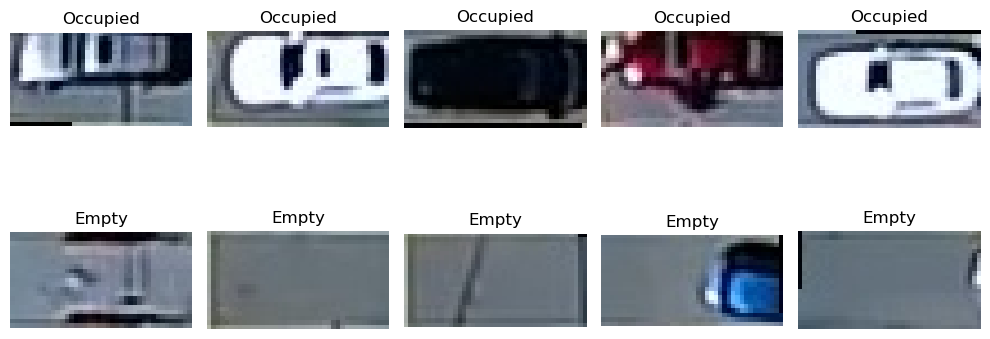

In [12]:
# displaying the dataset

import random

train_data_path = 'datasets/train/'
occupied = np.array(os.listdir(train_data_path + 'occupied'))
empty = np.array(os.listdir(train_data_path + 'empty'))

random_occ_indices = random.sample(range(0, len(occupied)), 5)
random_emp_indices = random.sample(range(0, len(empty)), 5)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Iterate over the image and mask pairs and display them in subplots
for i, (occ, emp) in enumerate(zip(occupied[random_occ_indices], empty[random_emp_indices])):
    # Load the image and mask using your preferred method
    occupied_stall = plt.imread(train_data_path + 'occupied/' + occ)
    empty_stall = plt.imread(train_data_path + 'empty/' + emp)

    # Plot the image and mask in the corresponding subplot
    axes[0, i].imshow(occupied_stall)
    axes[0, i].set_title('Occupied')
    axes[0, i].axis('off')

    axes[1, i].imshow(empty_stall)
    axes[1, i].set_title('Empty')
    axes[1, i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('samples.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()

<b>Load the dataset and apply label encoding</b>

In [5]:
# load the dataset
images, labels = load_data('datasets/train', SIZE, augmentation=True)


In [6]:
# hot encoding the labels
encoding = preprocessing.LabelEncoder()
encoding.fit(labels)
encoded_labels = encoding.transform(labels)

<b>Split data into train, val, and test</b>

In [7]:
# Split data to train, val, and test
X_train, X_test, y_train, y_test = train_test_split(np.array(images), encoded_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to between 0 and 1
X_train, X_val, X_test = X_train / 255.0, X_val/255.0, X_test / 255.0

<b>Load VGG 16 model</b>

In [8]:
# Load model without classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()  # Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

<b>Load XGBoost model</b>

In [9]:
# XGBOOST
import xgboost as xgb
from sklearn.metrics import accuracy_score

params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'logloss',  # 
    'eta': 0.1,  # learning rate
    'max_depth': 3,  # maximum depth of each tree
    'subsample': 0.8,  # subsample ratio of the training instances
    'colsample_bytree': 0.8,  # subsample ratio of features when constructing each tree
    'seed': 42  # random seed for reproducibility
}


XGB_model = xgb.XGBClassifier(**params)

<b>Extract features and train the XGBoost model</b>

In [10]:
with tf.device("/GPU:0"):
    feature_extractor = VGG_model.predict(X_train)
    # reshape the features to 2 dimentional vectors
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
    # start training
    XGB_model.fit(features, y_train)


 1/22 [>.............................] - ETA: 3s

2023-06-19 15:05:15.014265: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/22 [==============================] - 0s 7ms/step


<b>Predict and evaluate the test set</b>

In [11]:
with tf.device("/GPU:0"):
    # Send test data through same feature extractor process
    X_test_features = VGG_model.predict(X_test)
    X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)
    
    # Make predictions on the test set
    y_pred = XGB_model.predict(X_test_features)
    
    # Evaluate the model's performance on the test set
    accuracy = accuracy_score(y_test, y_pred)
    
print('Test Accuracy:', accuracy)

7/7 [==============================] - 0s 12ms/step
Test Accuracy: 0.9817351598173516


<b>Save the model</b>

In [12]:
with open('./models/XGBoost.pkl', 'wb') as file:
    pickle.dump(XGB_model, file)

In [13]:
# Re-Load the saved model from the file
with open('./models/XGBoost.pkl', 'rb') as file:
    XGB_model = pickle.load(file)

In [14]:
video_path = 'datasets/test/parkinglot.mov'
mask_path = 'datasets/test/mask.png'
output_folder_path = 'output/frames/'

with tf.device("/GPU:0"):
    parking_counter(video_path, mask_path, output_folder_path, SIZE, VGG_model, XGB_model)

1/1 [==============================] - 0s 9ms/step


In [2]:
# convert frame to gif
frames_folder = 'output/frames/'
output_path = 'output/output.gif'
duration = 25

convert_frames_to_gif(frames_folder, output_path, duration)

GIF conversion complete.


In [9]:
#import sys
#!conda install --yes --prefix {sys.prefix} pygifsicle